### Imports

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

### Discriminator Network

In [2]:
class Disc_Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv_layer = nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1,
                bias=True,
                padding_mode="reflect",
            )
        self.instance_norm = nn.InstanceNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.block = nn.Sequential(self.conv_layer, self.instance_norm,
                                   self.leaky_relu)

    def forward(self, x):
        return self.block(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.first_conv_layer = nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            )
        self.first_leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.initial = nn.Sequential(self.first_conv_layer,
                                     self.first_leaky_relu)

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Disc_Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        # Last Conv Layer
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)
        self.linear = nn.Linear(900, 1)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        # Flattening the output from Convolution Layer
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return torch.sigmoid(x)

In [3]:
def test_discriminator_shapes():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    assert preds.shape[0] == 5 and preds.shape[1] == 1
    return preds

output = test_discriminator_shapes()

### Generator Network

In [4]:
class Gen_Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, use_act=True, **kwargs):
        super().__init__()
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
        else:
            conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)
        self.gen_block = nn.Sequential(
            conv,
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.gen_block(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            Gen_Block(channels, channels, kernel_size=3, padding=1),
            Gen_Block(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x) # Residual Connection


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.down_blocks = nn.ModuleList(
            [
                Gen_Block(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                Gen_Block(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                Gen_Block(
                    num_features * 4,
                    num_features * 2,
                    downsample=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                Gen_Block(
                    num_features * 2,
                    num_features * 1,
                    downsample=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_conv_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last_conv_layer(x))


In [5]:
def test_generator_shapes():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    out = gen(x)
    assert out.shape[0] == 2 and out.shape[1] == 3 and out.shape[2] == 256 and out.shape[3] == 256
    return out

output = test_generator_shapes()

### Loading the Horse2Zebra Dataset

In [6]:
!ls ./drive/MyDrive/datasets/horse2zebra/

test  train


In [7]:
my_transforms = v2.Compose(
    [
        v2.Resize(size=(256, 256)),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        v2.ToTensor(),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [123]:
my_transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

In [124]:
class Horse2Zebra(Dataset):
    def __init__(self, zebra_path, horse_path, transform=None):
        self.zebra_path = zebra_path
        self.horse_path = horse_path
        self.transform = transform

        self.zebra_images = os.listdir(self.zebra_path)
        self.horse_images = os.listdir(self.horse_path)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.zebra_path, zebra_img)
        horse_path = os.path.join(self.horse_path, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        # if self.transform:
        #     zebra_img = self.transform(zebra_img)
        #     horse_img = self.transform(horse_img)

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

In [125]:
dataset = Horse2Zebra(zebra_path='./drive/MyDrive/datasets/horse2zebra/train/B/',
                      horse_path='./drive/MyDrive/datasets/horse2zebra/train/A/',
                      transform=my_transforms)

In [126]:
dataloader = DataLoader(dataset, batch_size=8,
                        shuffle=True, num_workers=2,
                        pin_memory=True, drop_last=True)

In [127]:
sample = next(iter(dataloader))

In [128]:
sample[0].shape, sample[1].shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]))

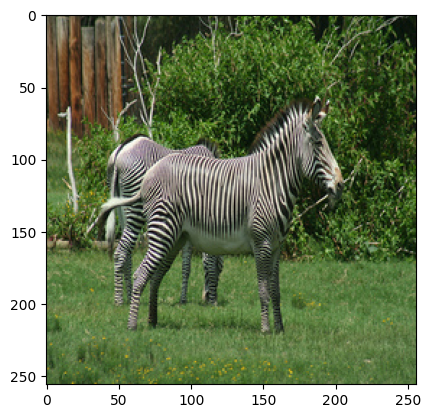

In [130]:
plt.imshow(sample[0][0].permute(1, 2, 0) * 0.5 + 0.5)

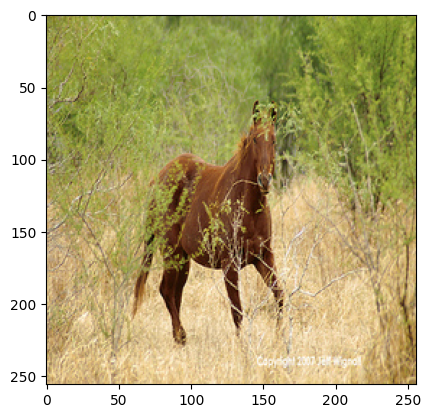

In [131]:
plt.imshow(sample[1][0].permute(1, 2, 0) * 0.5 + 0.5)

### Initialzing Models and Optimizers

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.00005
# lambda_adversarial = 1.0 # Scaler for Adversarial Loss
# lambda_cycle = 1.0 # Scaler for Cycle Consistency Loss
# lambda_identity = 0.25 # Scaler for Identity Loss

# Discriminator Models
disc_H = Discriminator(in_channels=3).to(device)
disc_Z = Discriminator(in_channels=3).to(device)

# Generator Models
gen_Z = Generator(img_channels=3, num_residuals=9).to(device)
gen_H = Generator(img_channels=3, num_residuals=9).to(device)

# Optimizer for Discriminators
opt_disc = optim.Adam(
    list(disc_H.parameters()) + list(disc_Z.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
)

# Optimizer for Generator
opt_gen = optim.Adam(
    list(gen_Z.parameters()) + list(gen_H.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
)

# L1 Loss for Cycle-Consistency and Identity Loss
L1 = nn.L1Loss()
# MSE Loss for Adversarial Loss, You can try BCE as well.
mse = nn.MSELoss()

In [133]:
device

'cuda'

### Gradient Scalers

In [134]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [135]:
def train_discriminators(horse, zebra):
    # Train Discriminators H and Z
    with torch.cuda.amp.autocast():
        fake_horse = gen_H(zebra)
        D_H_real = disc_H(horse)
        D_H_fake = disc_H(fake_horse.detach())
        D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
        D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
        D_H_loss = D_H_real_loss + D_H_fake_loss

        fake_zebra = gen_Z(horse)
        D_Z_real = disc_Z(zebra)
        D_Z_fake = disc_Z(fake_zebra.detach())
        D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
        D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
        D_Z_loss = D_Z_real_loss + D_Z_fake_loss

        # put it togethor
        D_loss = (D_H_loss + D_Z_loss)

    opt_disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()
    return D_loss.item(), fake_horse, fake_zebra

In [136]:
def train_generators(horse, zebra, fake_horse, fake_zebra, hyperparams):
    # Train Generators H and Z
    with torch.cuda.amp.autocast():
        # adversarial loss - Equation 1
        D_H_fake = disc_H(fake_horse)
        D_Z_fake = disc_Z(fake_zebra)
        loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
        loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

        # cycle loss - Equation 2
        cycle_zebra = gen_Z(fake_horse)
        cycle_horse = gen_H(fake_zebra)
        cycle_zebra_loss = L1(zebra, cycle_zebra)
        cycle_horse_loss = L1(horse, cycle_horse)

        # identity loss - Equation 3
        identity_zebra = gen_Z(zebra)
        identity_horse = gen_H(horse)
        identity_zebra_loss = L1(zebra, identity_zebra)
        identity_horse_loss = L1(horse, identity_horse)

        # adding all togethor - Equation 4
        G_loss = (
            loss_G_Z * hyperparams['lambda_adversarial']
            + loss_G_H * hyperparams['lambda_adversarial']
            + cycle_zebra_loss * hyperparams['lambda_cycle']
            + cycle_horse_loss * hyperparams['lambda_cycle']
            + identity_horse_loss * hyperparams['lambda_identity']
            + identity_zebra_loss * hyperparams['lambda_identity']
        )

    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()
    return G_loss.item()

### Training Loop

In [137]:
!rm -r results
!mkdir results

In [138]:
!mkdir results/zebra
!mkdir results/horse
!mkdir results/horse_org
!mkdir results/zebra_org

In [139]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 100

hyperparams = {
    'lambda_adversarial': 2.0,
    'lambda_cycle': 10.0,
    'lambda_identity': 0.5,
}

for epoch in range(num_epochs):
  D_losses = []
  G_losses = []
  for idx, (zebra, horse) in enumerate(dataloader):
    zebra, horse = zebra.to(device), horse.to(device)
    D_loss, fake_horse, fake_zebra = train_discriminators(horse, zebra)
    G_loss = train_generators(horse, zebra, fake_horse, fake_zebra, hyperparams)
    D_losses.append(D_loss)
    G_losses.append(G_loss)

    if idx % 50 == 0:
      print(f"Epoch {epoch}/{num_epochs}, Batch {idx}/{len(dataloader)}, D_loss: {np.mean(D_loss):.4f}, G_loss: {np.mean(G_loss):.4f}")
      # Original Images
      save_image((zebra[0] * 0.5 + 0.5),  f"./results/zebra_org/zebra_{epoch}_{idx}.png")
      save_image((horse[0] * 0.5 + 0.5),  f"./results/horse_org/horse_{epoch}_{idx}.png")
      # Generated Images
      save_image((fake_horse[0] * 0.5 + 0.5), f"./results/horse/horse_{epoch}_{idx}.png")
      save_image((fake_zebra[0] * 0.5 + 0.5), f"./results/zebra/zebra_{epoch}_{idx}.png")

Epoch 0/100, Batch 0/166, D_loss: 0.9889, G_loss: 12.1892
Epoch 0/100, Batch 50/166, D_loss: 0.9401, G_loss: 8.4025
Epoch 0/100, Batch 100/166, D_loss: 1.0257, G_loss: 7.4299
Epoch 0/100, Batch 150/166, D_loss: 0.7817, G_loss: 8.0992
Epoch 1/100, Batch 0/166, D_loss: 0.8767, G_loss: 6.6882
Epoch 1/100, Batch 50/166, D_loss: 0.8264, G_loss: 7.2541
Epoch 1/100, Batch 100/166, D_loss: 0.9355, G_loss: 7.2954
Epoch 1/100, Batch 150/166, D_loss: 0.9145, G_loss: 6.9074
Epoch 2/100, Batch 0/166, D_loss: 0.7332, G_loss: 7.1658
Epoch 2/100, Batch 50/166, D_loss: 0.5743, G_loss: 7.1509
Epoch 2/100, Batch 100/166, D_loss: 0.9002, G_loss: 6.7520
Epoch 2/100, Batch 150/166, D_loss: 0.7577, G_loss: 6.6276
Epoch 3/100, Batch 0/166, D_loss: 0.6091, G_loss: 6.3450
Epoch 3/100, Batch 50/166, D_loss: 0.6895, G_loss: 6.7872
Epoch 3/100, Batch 100/166, D_loss: 0.6181, G_loss: 6.6144
Epoch 3/100, Batch 150/166, D_loss: 0.9666, G_loss: 6.6496
Epoch 4/100, Batch 0/166, D_loss: 0.6077, G_loss: 6.2695
Epoch 4/10